# Praca domowa 7
## Karol Degórski

## Wykrywanie próbek odstajacych z użyciem algorytmu GMM

## Import potrzebnych pakietów

In [1]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

## Wczytanie danych *Wine*

Zbiór danych Wine pochodzi ze strony https://archive.ics.uci.edu/ml/datasets/wine. Zawiera on dane o winach. Dane zostały już podzielone na zbiór treningowy, walidacyjny i testowy, zatem wczytam od razu te 3 podzbiory i wyświetlę zbiór treningowy

In [2]:
wine_train = pd.read_csv('train.csv')
wine_val = pd.read_csv('val.csv')
wine_test = pd.read_csv('test.csv')

In [3]:
wine_train

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.300000,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.520000,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.600000,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.680000,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.010000,0.57,1.64,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,12.84,2.96,2.61,24.0,101,2.32,0.60,0.53,0.81,4.920000,0.89,2.15,590
91,12.70,3.87,2.40,23.0,101,2.83,2.55,0.43,1.95,2.570000,1.19,3.13,463
92,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470
93,12.88,2.99,2.40,20.0,104,1.30,1.22,0.24,0.83,5.400000,0.74,1.42,530


Widzimy, że w zbiorze treningowym mamy 95 rekordów. Sprawdźmy rozmiary pozostałych zbiorów

In [4]:
print(wine_val.shape)
print(wine_test.shape)

(17, 13)
(17, 14)


Zatem zbiór walidacyjny zawiera 17 rekordów. Zbiór testowy również zawiera 17 rekordów, ale poza tym ma on 14 kolumn, ponieważ zawiera również informację, o tym czy dany rekord jest outlierem (kolumna class: 1 - jeśli jest outlierem, 0 - gdy jest inlierem)

Sprawdźmy ile mamy outlierów w zbiorze testowym

In [5]:
wine_test.loc[np.where(wine_test['class'] == 1)].shape[0]

5

Widzimy zatem, że jest 5 outlierów w zbiorze testowym i tyle też chcielibyśmy wykryć

Zapisujemy również nazwy kolumn zbiorów

In [6]:
cols_train = wine_train.columns
cols_val = wine_val.columns
cols_test = wine_test.columns

## Wykrywanie outlierów

In [7]:
wine_test_cl = copy.deepcopy(wine_test)

In [8]:
wine_test = wine_test.drop('class', axis=1)

**GaussianMixture**

Importujemy GaussianMixture i trenujemy go na zbiorze treningowym

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
gmm = GaussianMixture(n_components=1, covariance_type='full')
gmm.fit(wine_train)

GaussianMixture()

Rysujemy histogram w celu znalezienia punktu odcięcia dla którego będziemy uznawali już dany rekord za outlier

Histogram dla zbioru **treningowego**

In [11]:
sc_train = gmm.score_samples(wine_train)

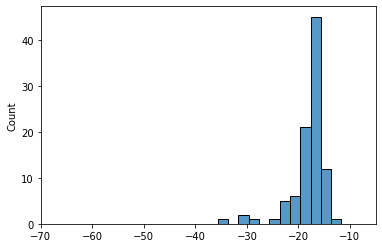

In [12]:
hi_train = sns.histplot(sc_train, binwidth=2)
hi_train.set(xlim=(-70, -5))
plt.show()

Sprawdźmy jaka jest wartość minimalna

In [13]:
min(sc_train)

-35.632145622230794

Histogram dla zbioru **walidacyjnego**

In [14]:
sc_val = gmm.score_samples(wine_val)

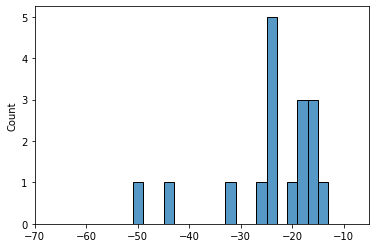

In [15]:
hi_val = sns.histplot(sc_val, binwidth=2)
hi_val.set(xlim=(-70, -5))
plt.show()

Po przeanalizowaniu wykresów możemy uznać threshold = -30 za optymalny. Wydaje się on optymalny, bo w zbiorze walidacyjnym widzimy wyraźne oddalenie dla tych wartości, a ponadto w zbiorze treningowym wykrywa on tylko jeden rekord nadmiarowo jako outlier. Jako, że mamy do czynienia z produktem spożywczym, jakim jest wino, to lepiej zaklasyfikować trochę więcej rekordów jako outliery, niż za mało.

In [16]:
thresh = -30

Dla pewności sprawdzamy w zbiorze walidacyjnym czy wykryliśmy trzy outliery znalezione na histogramie

In [17]:
outliers_val = wine_val.loc[np.where(sc_val <= thresh)]
outliers_val.columns = cols_val
outliers_val

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
7,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.2,1.08,2.85,1045
12,13.87,1.90,2.80,19.4,107,2.95,2.97,0.37,1.76,4.5,1.25,3.40,915
16,13.72,1.43,2.50,16.7,108,3.40,3.67,0.19,2.04,6.8,0.89,2.87,1285


Jak widzimy, wykryliśmy trzy outliery na zbiorze walidacyjnym

### Sprawdzamy na zbiorze testowym

In [18]:
sc_test = gmm.score_samples(wine_test)

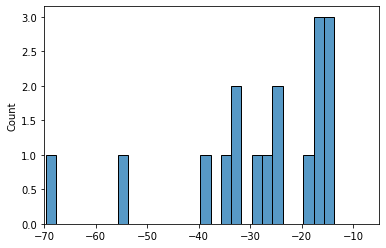

In [19]:
hi_test = sns.histplot(sc_test, binwidth=2)
hi_test.set(xlim=(-70, -5))
plt.show()

In [20]:
outliers_test = wine_test_cl.loc[np.where(sc_test <= thresh)]
outliers_test.columns = cols_test
outliers_test

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
3,0,12.47,1.52,2.20,19.0,162,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937
12,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
13,1,14.22,1.70,2.30,16.3,118,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970
14,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
15,1,14.75,1.73,2.39,11.4,91,3.10,3.69,0.43,2.81,5.40,1.25,2.73,1150
16,1,13.58,1.66,2.36,19.1,106,2.86,3.19,0.22,1.95,6.90,1.09,2.88,1515


Widzimy, że wykryliśmy 6 z 5 outlierów na zbiorze testowym, czyli o jeden za dużo. Sprawdźmy teraz wartości metryk

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [22]:
f1 = f1_score(wine_test_cl.iloc[:,0], sc_test<thresh)
print(f'f1_score = {round(f1, 2)}')

f1_score = 0.91


In [23]:
prec = precision_score(wine_test_cl.iloc[:,0], sc_test<thresh)
print(f'precision_score = {round(prec, 2)}')

precision_score = 0.83


In [24]:
rec = recall_score(wine_test_cl.iloc[:,0], sc_test<thresh)
print(f'recall_score = {round(rec, 2)}')

recall_score = 1.0


Widzimy, że osiągneliśmy bardzo dobre wyniki powyższych metryk

### Wizualizacja wykrywania outlierów

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(wine_train)

In [26]:
hu = pd.DataFrame(pd.Series(sc_test <= thresh)).replace({True: 'Outlier', False: 'Inlier'}).squeeze().rename('Type')

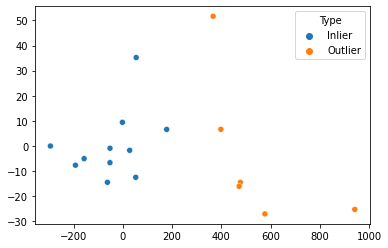

In [27]:
pca_test = pca.transform(wine_test)
sns.scatterplot(x=pca_test[:,0], y=pca_test[:,1], hue = hu)
plt.show()

Widzimy, że wykryte przez nas outliery na zbiorze testowym mogłyby być outlierami w rzeczywistości (5 z nich istotnie jest outlierami, a jeden jest nadmiarowy)

### Podsumowanie

Patrząc na wartości powyższych metryk widzimy, że GaussianMixture całkiem dobrze działa i może być wykorzystywany do wykrywania outlierów. Jednkaże, być może jest to własność tego zbioru danych i należałoby przetestować działanie tej metody wykrywania outlierów na innych zbiorach. Ponadto wybór optymalnego tresholdu może być kluczowy do osiągnięcia dobrych wyników.